In [2]:
# -*- coding: utf-8 -*-
"""
Created on Sun Sep 18 12:00:51 2022

@author: Gerard
"""

# conda install -c conda-forge mne
# conda install -c conda-forge pyvistaqt
# conda install -c conda-forge ipywidgets
# conda install -c conda-forge darkdetect


import os
import mne
import numpy as np
from mne.decoding import CSP
import matplotlib.pyplot as plt
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Load data sets

In [3]:
data_loo = mne.io.read_epochs_eeglab(input_fname = "AEP/Subject_13_H_AEP_Run_01.set")
data_tst = mne.io.read_epochs_eeglab(input_fname = "AEP/Subject_11_H_AEP_Run_01.set")

print(data_loo.info)
print(data_tst.info)

Extracting parameters from C:\Users\fafou\PycharmProjects\man&machine\AEP\Subject_13_H_AEP_Run_01.set...
Not setting metadata
480 matching events found
No baseline correction applied
0 projection items activated
Ready.
Extracting parameters from C:\Users\fafou\PycharmProjects\man&machine\AEP\Subject_11_H_AEP_Run_01.set...
Not setting metadata
480 matching events found
No baseline correction applied
0 projection items activated
Ready.
<Info | 8 non-empty values
 bads: []
 ch_names: FCz, C3, Cz, C4, CP1, CPZ, CP2, PZ
 chs: 8 EEG
 custom_ref_applied: False
 dig: 8 items (8 EEG)
 highpass: 0.0 Hz
 lowpass: 128.0 Hz
 meas_date: unspecified
 nchan: 8
 projs: []
 sfreq: 256.0 Hz
>
<Info | 8 non-empty values
 bads: []
 ch_names: FCz, C3, Cz, C4, CP1, CPZ, CP2, PZ
 chs: 8 EEG
 custom_ref_applied: False
 dig: 8 items (8 EEG)
 highpass: 0.0 Hz
 lowpass: 128.0 Hz
 meas_date: unspecified
 nchan: 8
 projs: []
 sfreq: 256.0 Hz
>


    Using multitaper spectrum estimation with 7 DPSS windows


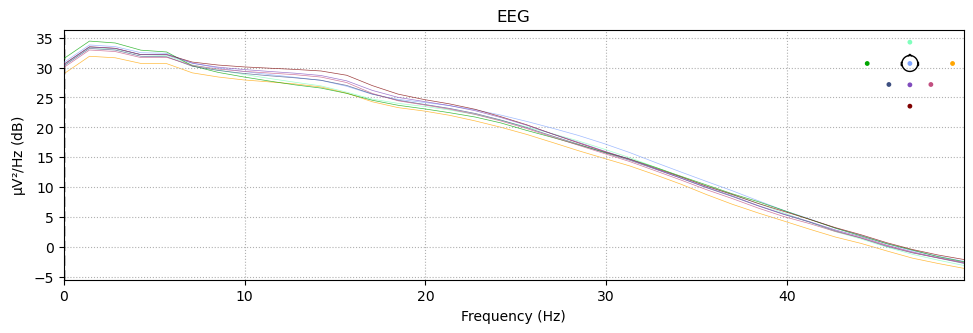

Setting up band-pass filter from 12 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 12.00
- Lower transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 10.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 283 samples (1.105 sec)



C:\Users\fafou\AppData\Local\Temp\ipykernel_7584\3196495510.py:4: RuntimeWarning: filter_length (283) is longer than the signal (180), distortion is likely. Reduce filter length or filter a longer signal.
  data_loo.filter(12., 30., fir_design='firwin')
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=1)]: Done 3840 out of 3840 | elapsed:    0.8s finished


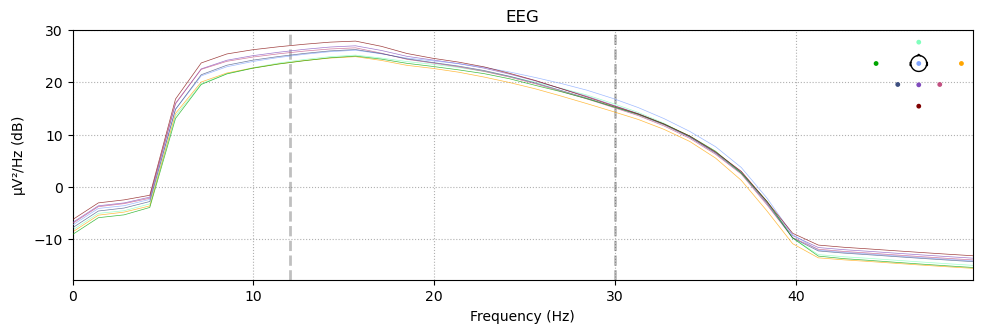

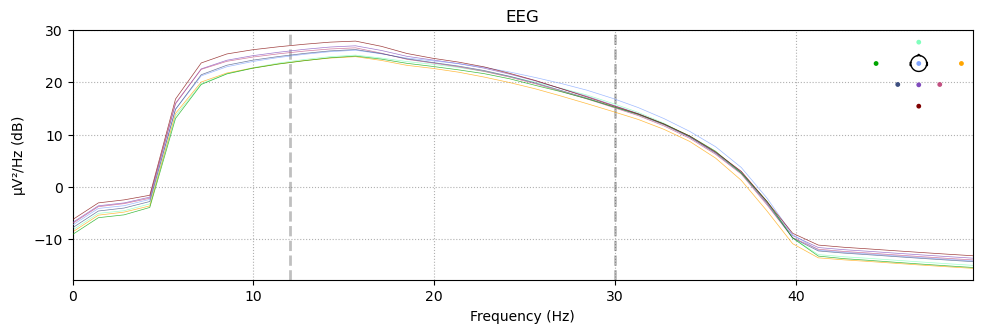

In [4]:
data_loo.plot_psd(fmax=50)

# band-pass filtering in the range 1 Hz - 50 Hz
data_loo.filter(12., 30., fir_design='firwin')

data_loo.plot_psd(fmax=50)

In [5]:
events_num = data_loo.events
event_id = {'Frequent': 1, 'Target': 2}
data_loo.plot(butterfly=False, events=events_num, event_id=event_id)

C:\Users\fafou\miniconda3\envs\manNmachine\lib\site-packages\pyqtgraph\colors\palette.py:1: RuntimeWarning: PyQtGraph supports Qt version >= 5.15, but 5.12.9 detected.
  from ..Qt import QtGui


Using qt as 2D backend.


In [6]:
t = data_loo.times
x = data_loo.get_data()
y = data_loo.events[:,2]
x_csp_average = CSP(n_components=6, transform_into='average_power').fit_transform(x, y)

print(x_csp_average)

Computing rank from data with rank=None
    Using tolerance 5.9e-06 (2.2e-16 eps * 8 dim * 3.3e+09  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 2e-06 (2.2e-16 eps * 8 dim * 1.1e+09  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
[[-1.24825086 -1.52327363 -1.21002713 -0.6837198  -0.72810185 -1.11533664]
 [-1.45895624 -1.27542844 -0.96844345 -1.12181532 -1.11424811 -1.2774302 ]
 [-1.60544041 -0.51388949 -0.96487708 -0.06119294 -0.56596444 -1.86417862]
 ...
 [-0.48921939 -0.74946541 -0.47940078 -0.29825047 -0.56494737 -0.34136854]
 [-1.33083771 -1.1468668  -1.09958213 -1.11964491 -1.73055676 -1.4649299 ]
 [-1.44474839 -1.03362039 -1.53072068 -1.6187303

In [7]:
print(x_csp_average.shape)
print(y.shape)

(480, 6)
(480,)


We start by searching the best model to use with this dataset. We are going to compare 3 classifier models : Decision Tree, K-nearest neighbors and Multilayer perceptron.

In [8]:
loo = LeaveOneOut()

tree = DecisionTreeClassifier()
knn = KNeighborsClassifier()
nnet = MLPClassifier()

y_pred_tree = cross_val_predict(tree, x_csp_average, y, cv=loo, n_jobs=-1)
y_pred_knn = cross_val_predict(knn, x_csp_average, y, cv=loo, n_jobs=-1)
y_pred_nnet = cross_val_predict(nnet, x_csp_average, y, cv=loo, n_jobs=-1)

matrix_tree = confusion_matrix(y, y_pred_tree)
matrix_knn = confusion_matrix(y, y_pred_knn)
matrix_nnet = confusion_matrix(y, y_pred_nnet)

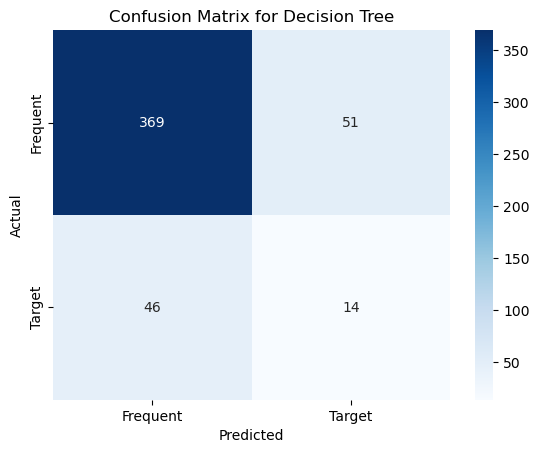

In [9]:
sns.heatmap(matrix_tree, annot=True, xticklabels=['Frequent', 'Target'], yticklabels=['Frequent', 'Target'], cmap="Blues", fmt="g")
plt.xlabel('Predicted'); plt.ylabel('Actual'); plt.title('Confusion Matrix for Decision Tree')
plt.show()

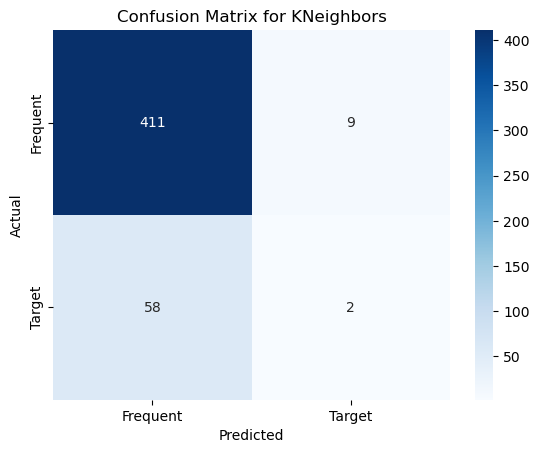

In [11]:
sns.heatmap(matrix_knn, annot=True, xticklabels=['Frequent', 'Target'], yticklabels=['Frequent', 'Target'], cmap="Blues", fmt="g")
plt.xlabel('Predicted'); plt.ylabel('Actual'); plt.title('Confusion Matrix for KNeighbors')
plt.show()

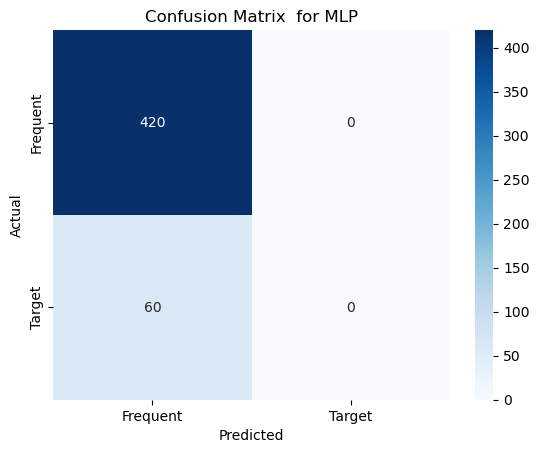

In [12]:
sns.heatmap(matrix_nnet, annot=True, xticklabels=['Frequent', 'Target'], yticklabels=['Frequent', 'Target'], cmap="Blues", fmt="g")
plt.xlabel('Predicted'); plt.ylabel('Actual'); plt.title('Confusion Matrix  for MLP')
plt.show()

The best model is undoubtedly the decision tree. This is the model we will use for the following.
We will train it on the data used so far and then we will test it on new data.

In [13]:
tree.fit(x_csp_average, y)

DecisionTreeClassifier()

In [14]:
t_tst = data_tst.times
x_tst = data_tst.get_data()
y_tst = data_tst.events[:,2]
x_csp_average_tst = CSP(n_components=6, transform_into='average_power').fit_transform(x_tst, y_tst)

Computing rank from data with rank=None
    Using tolerance 1.7e-05 (2.2e-16 eps * 8 dim * 9.4e+09  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 6.9e-06 (2.2e-16 eps * 8 dim * 3.9e+09  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.


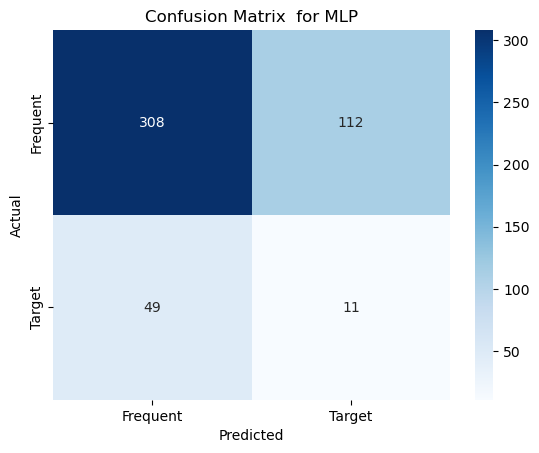

In [15]:
y_pred = tree.predict(x_csp_average_tst)
matrix = confusion_matrix(y_tst, y_pred)

sns.heatmap(matrix, annot=True, xticklabels=['Frequent', 'Target'], yticklabels=['Frequent', 'Target'], cmap="Blues", fmt="g")
plt.xlabel('Predicted'); plt.ylabel('Actual'); plt.title('Confusion Matrix  for MLP')
plt.show()

The results are pretty satisfying